In [ ]:
# ================================
# RQ4 — Sensitivity (OAT + Grid)
# ================================



# --- Imports ---
import os, re, glob, json, random
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras

# --- Reproducibility ---
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = '42'

# --------------------------
# Run/session + directories
# --------------------------
project_path = os.getenv('PROJECT_PATH', '.')

def _next_version(base_dir: str) -> int:
    os.makedirs(base_dir, exist_ok=True)
    existing = glob.glob(os.path.join(base_dir, r'v[0-9][0-9][0-9]*'))
    nums = []
    for p in existing:
        m = re.search(r'v(\d+)', os.path.basename(p))
        if m:
            nums.append(int(m.group(1)))
    return (max(nums) + 1) if nums else 1

def start_run(experiment: str, config: dict, root: str = project_path):
    base = os.path.join(root, 'runs', experiment)
    ver = _next_version(base)
    run_dir = os.path.join(base, f'v{ver:03d}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

    subdirs = ['figures', 'metrics', 'models', 'logs', 'configs','attributions']
    for sub in subdirs:
        os.makedirs(os.path.join(run_dir, sub), exist_ok=True)

    with open(os.path.join(run_dir, 'configs', 'config.json'), 'w') as f:
        json.dump(config, f, indent=2)
    with open(os.path.join(run_dir, 'configs', 'config.txt'), 'w') as f:
        for k, v in config.items():
            f.write(f"{k}: {v}\n")
    with open(os.path.join(run_dir, 'README.md'), 'w') as f:
        f.write(f"# Experiment: {experiment} (v{ver:03d})\n")
        f.write(f"Created: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("## Notes:\n- RQ4 sensitivity tests\n")

    paths = {name: os.path.join(run_dir, name) for name in subdirs}
    paths.update({
        "results_figures": os.path.join(project_path, "results/figures"),
        "results_metrics": os.path.join(project_path, "results/metrics"),
        "results_attributions": os.path.join(project_path, "results/attributions"),
        "project_root": project_path,
    })
    print(f'▶ New run: {experiment} v{ver:03d}\n  {run_dir}')
    return ver, run_dir, paths

CONFIG = {
    "experiment": "RQ4",
    "horizon": 7,
    "window": 40,
    "val_size": 0.10,
    "test_size": 0.20,
    "lstm1": 128,
    "lstm2": 64,
    "dropout": 0.05,
    "lr": 1e-3,
    "batch_size": 32,
    "epochs": 50,
}
VER, RUN_DIR, paths = start_run(CONFIG["experiment"], CONFIG)

# -------------------------
# Robust save/dir helpers
# -------------------------
def _savefig(path, fig=None, dpi=300):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    (fig or plt.gcf()).savefig(path, dpi=dpi, bbox_inches="tight")
    print("Saved:", path)

def _resolve_dirs(figdir=None, metdir=None):
    """Resolve figures/metrics dirs robustly (no NameErrors)."""
    if figdir and metdir:
        os.makedirs(figdir, exist_ok=True); os.makedirs(metdir, exist_ok=True)
        return figdir, metdir
    # prefer per-run dirs
    if isinstance(paths, dict):
        f = paths.get("figures") or os.path.join(RUN_DIR, "figures")
        m = paths.get("metrics") or os.path.join(RUN_DIR, "metrics")
    else:
        f = os.path.join(RUN_DIR, "figures")
        m = os.path.join(RUN_DIR, "metrics")
    os.makedirs(f, exist_ok=True); os.makedirs(m, exist_ok=True)
    return f, m

# ----------------------------
# Data & feature engineering
# ----------------------------
def get_nvda_stock_data():
    """Fetch NVDA OHLCV from Yahoo Finance; fallback to local CSV if needed."""
    csv_path = os.path.join(project_path, 'data/raw/nvda_stock_data.csv')
    try:
        if os.path.exists(csv_path):
            return pd.read_csv(csv_path, parse_dates=True, index_col=0)
        import yfinance as yf
        nvda = yf.download("NVDA", start="2015-02-02", end="2025-05-01", auto_adjust=False)
        nvda.columns = nvda.columns.get_level_values(0)
        nvda = nvda.rename(columns={"Adj Close":"AdjClose"})
        os.makedirs(os.path.dirname(csv_path), exist_ok=True)
        nvda.to_csv(csv_path)
        return nvda
    except Exception as e:
        raise RuntimeError(f"Could not load NVDA data: {e}")

def _build_features(nvda_data, H=7):
    df = nvda_data.copy()
    df['log_ret_next'] = np.log(df['Close'].shift(-H) / df['Close'])
    df['RegimeLabel']  = (df['log_ret_next'] > 0).astype(int)

    # Tech indicators
    df['ema_delta'] = df['Close'].ewm(span=9, adjust=False).mean() - df['Close'].ewm(span=21, adjust=False).mean()
    df['sma_delta'] = df['Close'].rolling(window=5).mean() - df['Close'].rolling(window=10).mean()
    df['rolling_vol_20d'] = np.log(df['Close'] / df['Close'].shift(1)).rolling(window=20).std()

    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    df['rsi_14'] = 100 - (100 / (1 + rs))

    obv = [0]
    for i in range(1, len(df)):
        if df['Close'].iloc[i] > df['Close'].iloc[i-1]:
            obv.append(obv[-1] + df['Volume'].iloc[i])
        elif df['Close'].iloc[i] < df['Close'].iloc[i-1]:
            obv.append(obv[-1] - df['Volume'].iloc[i])
        else:
            obv.append(obv[-1])
    df['obv'] = obv

    bb_mean = df['Close'].rolling(window=20).mean()
    bb_std  = df['Close'].rolling(window=20).std()
    df['bollinger_bandwidth'] = ((bb_mean + 2*bb_std) - (bb_mean - 2*bb_std)) / (bb_mean)

    df['return_lag_1'] = np.log(df['Close'] / df['Close'].shift(1)).shift(1)

    df.dropna(subset=['log_ret_next','RegimeLabel'], inplace=True)
    df.dropna(inplace=True)
    # drop raw columns to match baseline
    df = df.drop(columns=['Open','High','Low','Volume','AdjClose'])
    return df

def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# --------------------
# Split/scale helpers
# --------------------
def reg_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    return dict(MSE=float(mse), RMSE=rmse, MAE=mae)

def _seq_split_scale(window, X_df, y_ser, val_size=0.10, test_size=0.20):
    window = int(window)
    X_seq, y_seq = create_sequences(X_df.values, y_ser.values.astype(float), window)
    n = len(X_seq)
    n_te = int(test_size * n); n_va = int(val_size * n); n_tr = n - n_va - n_te
    assert n_tr>0 and n_va>0 and n_te>0
    Xtr, Xva, Xte = X_seq[:n_tr], X_seq[n_tr:n_tr+n_va], X_seq[-n_te:]
    ytr, yva, yte = y_seq[:n_tr], y_seq[n_tr:n_tr+n_va], y_seq[-n_te:]

    n_feats = Xtr.shape[-1]
    fscaler = StandardScaler().fit(Xtr.reshape(-1, n_feats))
    Xtr_s = fscaler.transform(Xtr.reshape(-1, n_feats)).reshape(Xtr.shape)
    Xva_s = fscaler.transform(Xva.reshape(-1, n_feats)).reshape(Xva.shape)
    Xte_s = fscaler.transform(Xte.reshape(-1, n_feats)).reshape(Xte.shape)

    tscaler = StandardScaler().fit(ytr.reshape(-1,1))
    ytr_s = tscaler.transform(ytr.reshape(-1,1)).ravel()
    yva_s = tscaler.transform(yva.reshape(-1,1)).ravel()
    return (Xtr_s, ytr_s, Xva_s, yva_s, Xte_s, yte, fscaler, tscaler)


_SPLIT_CACHE = {}
def get_split_scaled(window):
    w = int(window)
    key = (w, float(CONFIG["val_size"]), float(CONFIG["test_size"]))
    if key in _SPLIT_CACHE:
        return _SPLIT_CACHE[key]


    if w == int(CONFIG["window"]) and all(k in globals() for k in [
        "X_train_scaled","y_train_scaled","X_val_scaled","y_val_scaled",
        "X_test_scaled","y_test","feat_scaler","tgt_scaler"
    ]):
        out = (
            X_train_scaled, y_train_scaled,
            X_val_scaled,   y_val_scaled,
            X_test_scaled,  y_test,
            feat_scaler,    tgt_scaler
        )
    else:
        nvda = get_nvda_stock_data()
        df   = _build_features(nvda, H=int(CONFIG["horizon"]))
        X_df = df.drop(columns=['RegimeLabel','log_ret_next','Close'])
        y_ser= df['log_ret_next'].astype(float)
        out  = _seq_split_scale(w, X_df, y_ser,
                                val_size=float(CONFIG["val_size"]),
                                test_size=float(CONFIG["test_size"]))
    _SPLIT_CACHE[key] = out
    return out




▶ New run: RQ4 v001
  /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v001_20250903-204537


In [ ]:
# -------------------------
# Model builder (LSTM)
# -------------------------
def build_lstm_arch(n_steps, n_feats,
                    num_layers,
                    lstm1,
                    lstm2=None,
                    lstm3=None,
                    dropout=0.0,
                    head_units=32,
                    lr=1e-3,
                    loss="mse"):
    Inp = keras.Input(shape=(n_steps, n_feats))
    x = keras.layers.LSTM(int(lstm1), return_sequences=(int(num_layers)>1),
                          dropout=float(dropout), recurrent_dropout=0.0)(Inp)
    x = keras.layers.Dropout(float(dropout))(x)
    if int(num_layers) >= 2:
        u2 = int(lstm2) if lstm2 is not None else 32
        x = keras.layers.LSTM(u2, return_sequences=(int(num_layers)>2),
                              dropout=float(dropout), recurrent_dropout=0.0)(x)
        x = keras.layers.Dropout(float(dropout))(x)
    if int(num_layers) == 3:
        u3 = int(lstm3) if lstm3 is not None else 32
        x = keras.layers.LSTM(u3, return_sequences=False,
                              dropout=float(dropout), recurrent_dropout=0.0)(x)
        x = keras.layers.Dropout(float(dropout))(x)
    if head_units and int(head_units) > 0:
        x = keras.layers.Dense(int(head_units), activation='relu')(x)
    out = keras.layers.Dense(1)(x)

    model = keras.Model(Inp, out)
    if str(loss).lower() == "huber":
        loss_fn = keras.losses.Huber(delta=1.0)
    else:
        loss_fn = loss
    model.compile(optimizer=keras.optimizers.Adam(float(lr)),
                  loss=loss_fn, metrics=['mae'])
    return model

def _agg_mean_std(metric_list):
    keys = ["MSE","RMSE","MAE"]
    mean = {k: float(np.mean([m[k] for m in metric_list])) for k in keys}
    std  = {f"{k}_std": float(np.std([m[k] for m in metric_list])) for k in keys}
    return {**mean, **std}


▶ OAT (architecture): 19 runs planned
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v017_20250902-125954/figures/oat_arch__window_vs_RMSE_sns.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v017_20250902-125954/figures/oat_arch__window_delta_RMSE_pct_sns.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v017_20250902-125954/figures/oat_arch__num_layers_vs_RMSE_sns.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v017_20250902-125954/figures/oat_arch__num_layers_delta_RMSE_pct_sns.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v017_20250902-125954/figures/oat_arch__lstm1_vs_RMSE_sns.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v017_20250902-125954/figures/oat_arch__lstm1_delta_RMSE_pct_sns.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v017_20250902-125954/figures/oat_arch__lstm2_vs_RMSE_sns.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v017_20250902-125954/f

,param,value,window,num_layers,lstm1,lstm2,lstm3,dropout,head_units,MSE,RMSE,MAE
12,dropout,0.00,40,2,128,64.0,NaN,0.00,32,0.007387,0.085948,0.067367
13,dropout,0.05,40,2,128,64.0,NaN,0.05,32,0.008936,0.094533,0.073881
14,dropout,0.20,40,2,128,64.0,NaN,0.20,32,0.009047,0.095117,0.075058
15,head_units,0.00,40,2,128,64.0,NaN,0.05,0,0.011144,0.105565,0.081235
16,head_units,16.00,40,2,128,64.0,NaN,0.05,16,0.010664,0.103269,0.081349
17,head_units,32.00,40,2,128,64.0,NaN,0.05,32,0.008936,0.094533,0.073881
18,head_units,64.00,40,2,128,64.0,NaN,0.05,64,0.010326,0.101617,0.080421
6,lstm1,64.00,40,2,64,64.0,NaN,0.05,32,0.007647,0.087446,0.069217
7,lstm1,128.00,40,2,128,64.0,NaN,0.05,32,0.008936,0.094533,0.073881
8,lstm2,32.00,40,2,128,32.0,NaN,0.05,32,0.008097,0.089983,0.072111


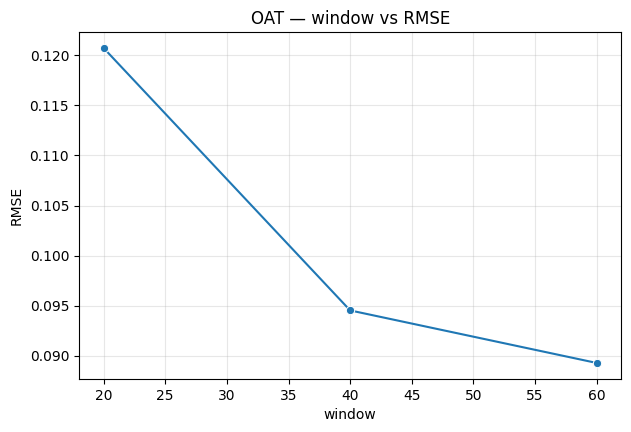

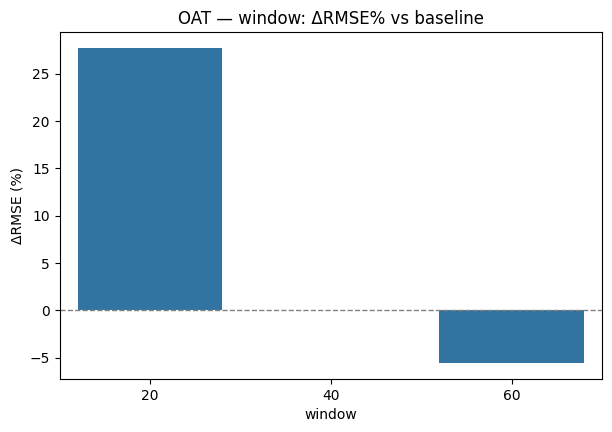

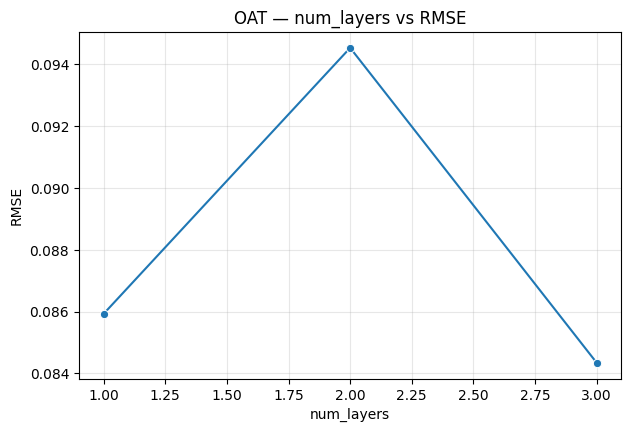

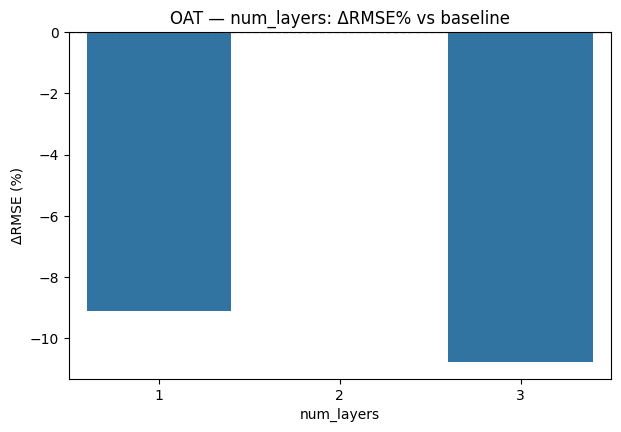

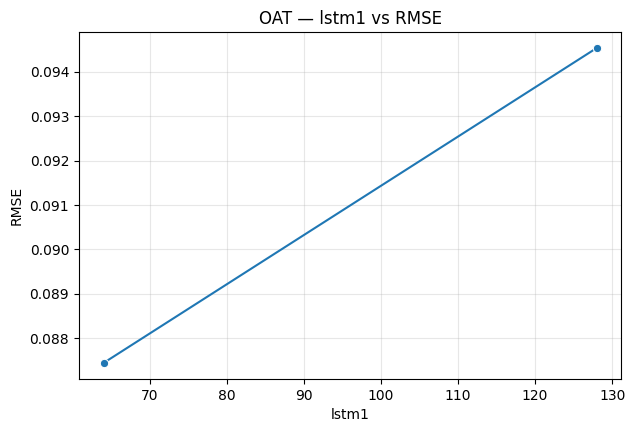

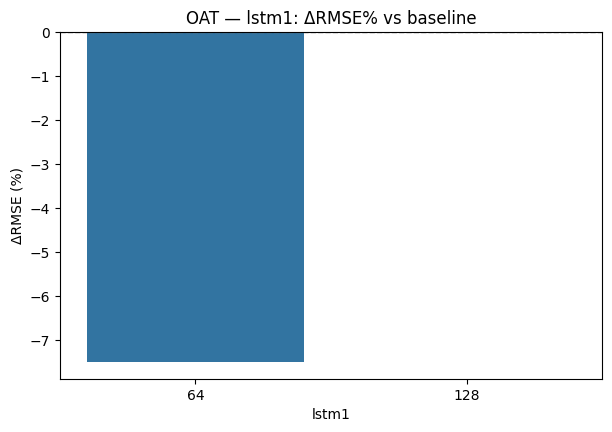

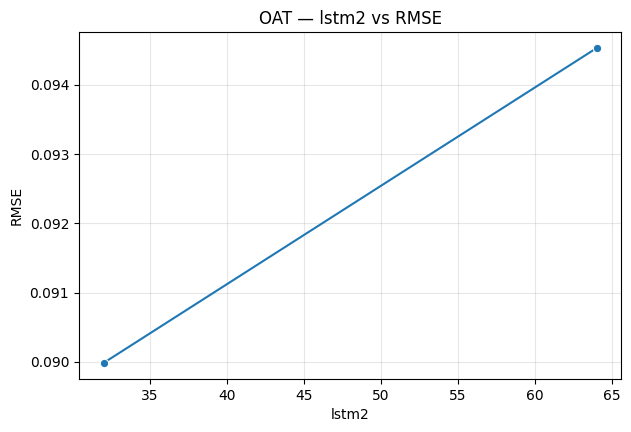

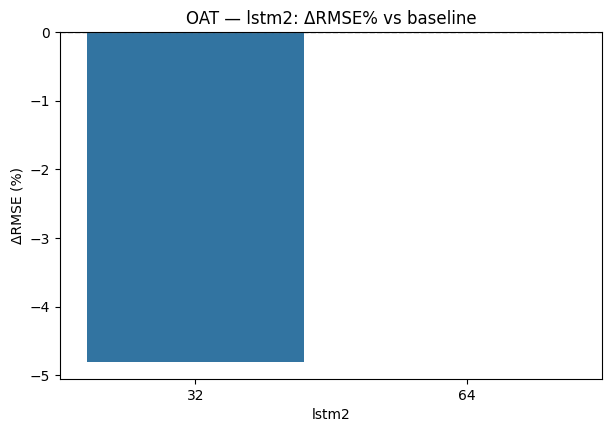

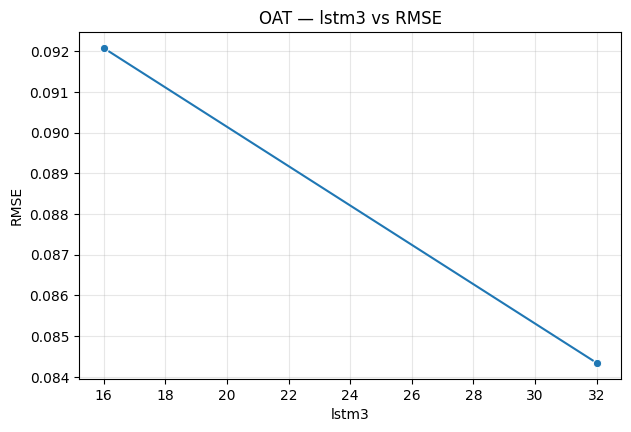

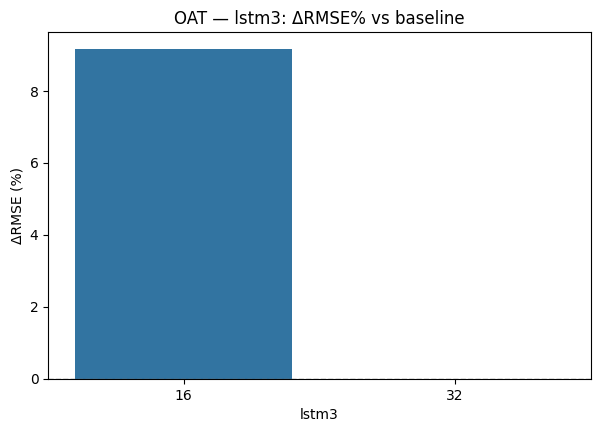

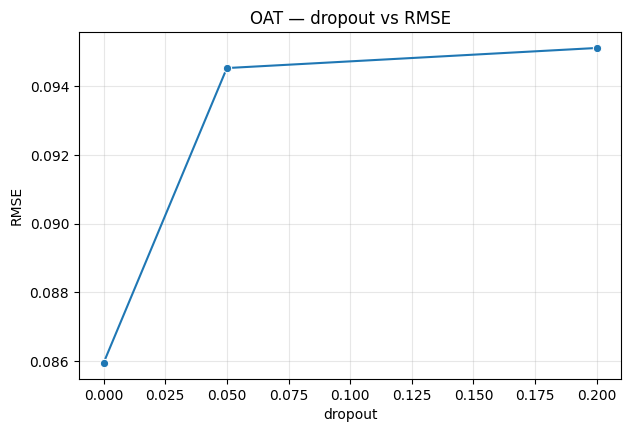

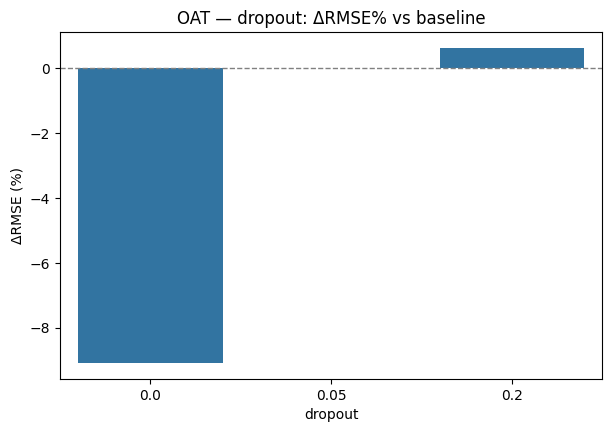

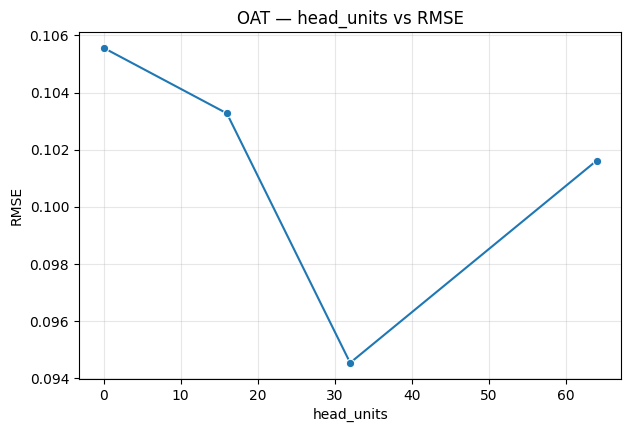

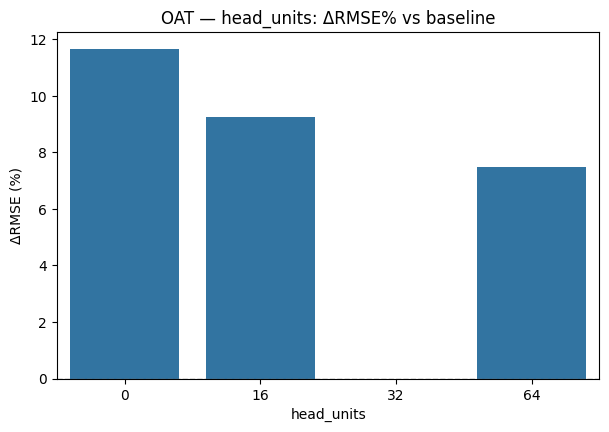

In [ ]:

# -------------------------
# Phase 2a — OAT: ARCH
# -------------------------
BASE_ARCH = dict(
    window     = int(CONFIG["window"]),
    num_layers = 2,
    lstm1      = int(CONFIG["lstm1"]),
    lstm2      = int(CONFIG["lstm2"]),
    lstm3      = 32,
    dropout    = float(CONFIG["dropout"]),
    head_units = 32
)
OAT_ARCH = {
    "window":     [20, 40, 60],
    "num_layers": [1, 2, 3],
    "lstm1":      [64, 128],
    "lstm2":      [32, 64],
    "lstm3":      [16, 32],
    "dropout":    [0.0, 0.05, 0.2],
    "head_units": [0, 16, 32, 64]
}

def run_oat_arch(oat=OAT_ARCH, base=BASE_ARCH, repeats=1, seed=4242, metric="RMSE", patience=10,
                 figdir=None, metdir=None):
    rows = []
    figdir, metdir = _resolve_dirs(figdir, metdir)
    total_runs = sum(len(v) for v in oat.values()) * max(1, int(repeats))
    print(f"▶ OAT (architecture): {total_runs} runs planned")

    for param, values in oat.items():
        for val in values:
            cfg = dict(base); cfg[param] = val
            if param == "lstm3": cfg["num_layers"] = 3
            if param == "lstm2": cfg["num_layers"] = max(cfg["num_layers"], 2)
            if int(cfg["num_layers"]) == 1:
                cfg["lstm2"] = None; cfg["lstm3"] = None
            elif int(cfg["num_layers"]) == 2:
                cfg["lstm3"] = None

            Xtr, ytr_s, Xva, yva_s, Xte, yte, fscaler, tscaler = get_split_scaled(int(cfg["window"]))
            n_steps, n_feats = Xtr.shape[1], Xtr.shape[2]

            met_list = []
            for rep in range(int(repeats)):
                tf.keras.utils.set_random_seed(seed + rep)
                model = build_lstm_arch(
                    n_steps, n_feats,
                    num_layers=int(cfg["num_layers"]),
                    lstm1=int(cfg["lstm1"]),
                    lstm2=(None if cfg.get("lstm2") is None else int(cfg["lstm2"])),
                    lstm3=(None if cfg.get("lstm3") is None else int(cfg["lstm3"])),
                    dropout=float(cfg["dropout"]),
                    head_units=int(cfg["head_units"]),
                    lr=float(CONFIG["lr"]),
                    loss="mse"
                )
                es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=int(patience), restore_best_weights=True)
                model.fit(Xtr, ytr_s, validation_data=(Xva, yva_s),
                          epochs=int(CONFIG["epochs"]), batch_size=int(CONFIG["batch_size"]),
                          shuffle=False, verbose=0, callbacks=[es])
                y_pred = tscaler.inverse_transform(model.predict(Xte, verbose=0).ravel().reshape(-1,1)).ravel()
                met_list.append(reg_metrics(yte, y_pred))

            rows.append(dict(param=param, value=val, **cfg, **_agg_mean_std(met_list)))

        # Per-parameter visuals
        df_tmp = pd.DataFrame([r for r in rows if r["param"] == param]).copy()

        try:
            df_tmp["value_num"] = pd.to_numeric(df_tmp["value"], errors="raise")
            xcol, xlabel = "value_num", param
            df_tmp = df_tmp.sort_values(xcol)
        except Exception:
            xcol, xlabel = "value", f"{param} (categorical)"
            df_tmp = df_tmp.sort_values(xcol)

        plt.figure(figsize=(7,4.5))
        yerr_col = f"{metric}_std"
        if yerr_col in df_tmp and df_tmp[yerr_col].notna().any() and repeats>1:
            sns.lineplot(data=df_tmp, x=xcol, y=metric, marker="o", errorbar=("sd"))
        else:
            sns.lineplot(data=df_tmp, x=xcol, y=metric, marker="o")
        plt.title(f"OAT — {param} vs {metric}"); plt.xlabel(xlabel); plt.ylabel(metric); plt.grid(True, alpha=.3)
        _savefig(os.path.join(figdir, f"oat_arch__{param}_vs_{metric}_sns.png"))

        base_mask = (df_tmp["value"] == base.get(param))
        if base_mask.any():
            base_val = float(df_tmp.loc[base_mask, metric].iloc[0])
            df_tmp["delta_pct"] = 100.0 * (df_tmp[metric] - base_val) / (base_val + 1e-12)
            plt.figure(figsize=(7,4.5))
            ax = sns.barplot(data=df_tmp, x=xcol, y="delta_pct")
            ax.axhline(0, ls="--", lw=1, color="gray")
            ax.set(title=f"OAT — {param}: Δ{metric}% vs baseline", xlabel=xlabel, ylabel=f"Δ{metric} (%)")
            _savefig(os.path.join(figdir, f"oat_arch__{param}_delta_{metric}_pct_sns.png"))

    df_all = pd.DataFrame(rows)
    out_csv = os.path.join(metdir, "oat_arch_sensitivity.csv")
    df_all.to_csv(out_csv, index=False)
    print(" Saved OAT ARCH sensitivity to:", out_csv)
    display(df_all.sort_values(["param","value"]).loc[
        :,
        ["param","value","window","num_layers","lstm1","lstm2","lstm3","dropout","head_units","MSE","RMSE","MAE"]
    ].head(30))
    return df_all

oat_arch_df  = run_oat_arch(repeats=1, metric="RMSE", patience=10)


▶ OAT (training): 12 runs planned
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v017_20250902-125954/figures/oat_train__loss_vs_RMSE_sns.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v017_20250902-125954/figures/oat_train__loss_delta_RMSE_pct_sns.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v017_20250902-125954/figures/oat_train__lr_vs_RMSE_sns.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v017_20250902-125954/figures/oat_train__lr_delta_RMSE_pct_sns.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v017_20250902-125954/figures/oat_train__batch_size_vs_RMSE_sns.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v017_20250902-125954/figures/oat_train__batch_size_delta_RMSE_pct_sns.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v017_20250902-125954/figures/oat_train__epochs_vs_RMSE_sns.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ4/v017_20250902-125954/figures

,param,value,loss,lr,batch_size,epochs,MSE,RMSE,MAE
6,batch_size,16,mse,0.0010,16,50,0.007675,0.087607,0.069909
7,batch_size,32,mse,0.0010,32,50,0.008149,0.090272,0.072755
8,batch_size,64,mse,0.0010,64,50,0.007078,0.084129,0.066772
9,epochs,30,mse,0.0010,32,30,0.008149,0.090272,0.072755
10,epochs,50,mse,0.0010,32,50,0.008149,0.090272,0.072755
11,epochs,100,mse,0.0010,32,100,0.008149,0.090272,0.072755
2,loss,huber,huber,0.0010,32,50,0.006958,0.083415,0.067351
1,loss,mae,mae,0.0010,32,50,0.008049,0.089716,0.071165
0,loss,mse,mse,0.0010,32,50,0.008149,0.090272,0.072755
3,lr,0.0001,mse,0.0001,32,50,0.007512,0.086672,0.068888


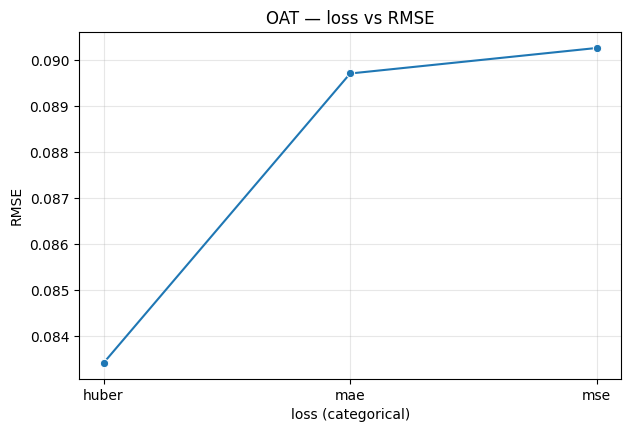

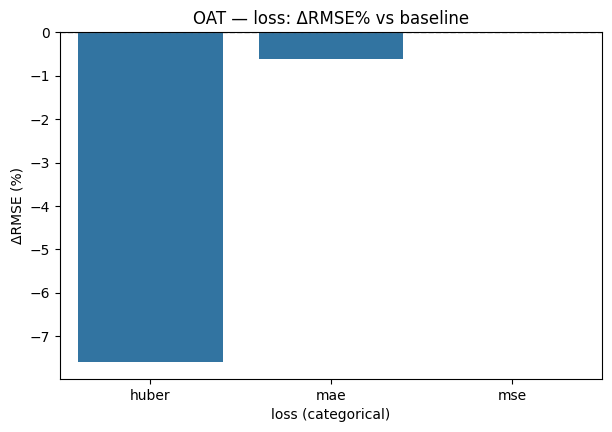

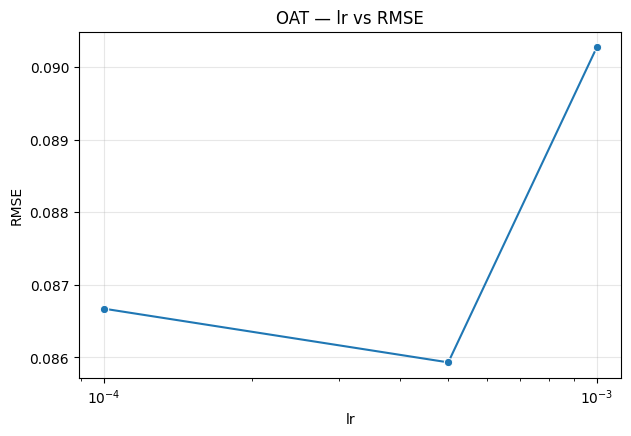

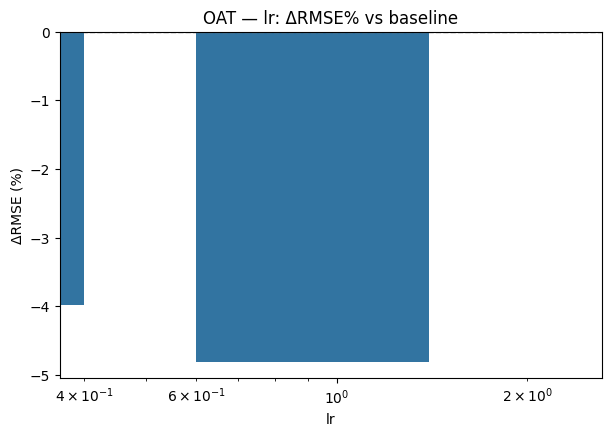

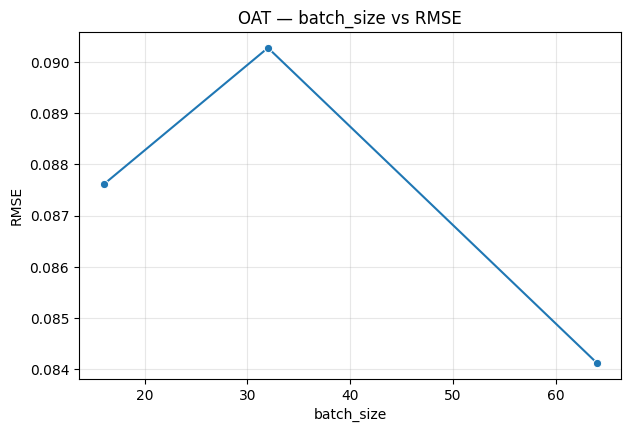

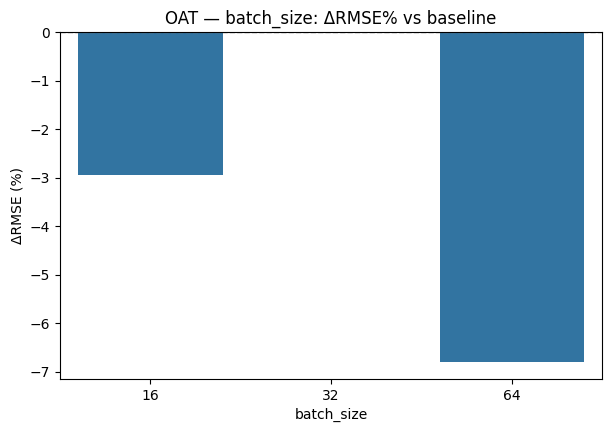

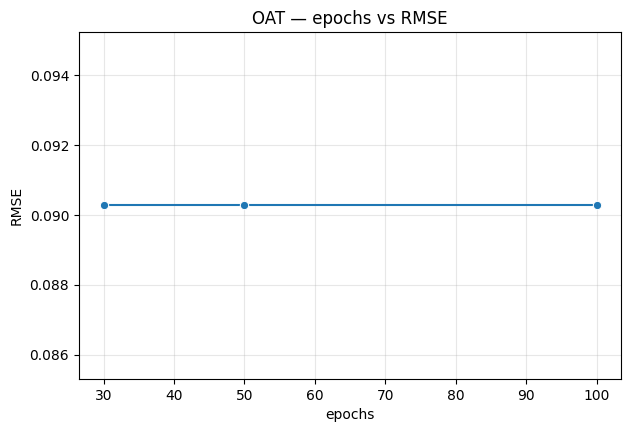

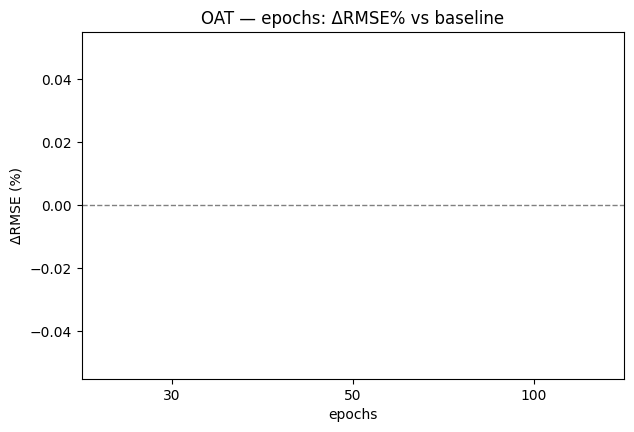

In [ ]:
# -------------------------
# Phase 2b — OAT: TRAINING
# -------------------------
BASE_TRAIN = dict(
    loss="mse",
    lr=float(CONFIG["lr"]),
    batch_size=int(CONFIG["batch_size"]),
    epochs=int(CONFIG["epochs"])
)
OAT_TRAIN = {
    "loss":       ["mse","mae","huber"],
    "lr":         [1e-4, 5e-4, 1e-3],
    "batch_size": [16, 32, 64],
    "epochs":     [30, 50, 100]
}

_FIXED_SPLIT = None
def get_fixed_split():
    global _FIXED_SPLIT
    if _FIXED_SPLIT is not None:
        return _FIXED_SPLIT
    if all(k in globals() for k in [
        "X_train_scaled","y_train_scaled","X_val_scaled","y_val_scaled",
        "X_test_scaled","y_test","feat_scaler","tgt_scaler"
    ]):
        _FIXED_SPLIT = (
            X_train_scaled, y_train_scaled,
            X_val_scaled,   y_val_scaled,
            X_test_scaled,  y_test,
            feat_scaler,    tgt_scaler
        )
    else:
        # build once for baseline window
        nvda = get_nvda_stock_data()
        df   = _build_features(nvda, H=int(CONFIG["horizon"]))
        X_df = df.drop(columns=['RegimeLabel','log_ret_next','Close'])
        y_ser= df['log_ret_next'].astype(float)
        _FIXED_SPLIT = _seq_split_scale(int(CONFIG["window"]), X_df, y_ser,
                                        val_size=float(CONFIG["val_size"]),
                                        test_size=float(CONFIG["test_size"]))
    return _FIXED_SPLIT

def run_oat_train(oat=OAT_TRAIN, base_arch=BASE_ARCH, base_train=BASE_TRAIN,
                  repeats=1, seed=555, metric="RMSE", patience=10,
                  figdir=None, metdir=None):
    Xtr, ytr_s, Xva, yva_s, Xte, yte, fscaler, tscaler = get_fixed_split()
    n_steps, n_feats = Xtr.shape[1], Xtr.shape[2]
    rows = []
    figdir, metdir = _resolve_dirs(figdir, metdir)
    total_runs = sum(len(v) for v in oat.values()) * max(1, int(repeats))
    print(f"▶ OAT (training): {total_runs} runs planned")

    def _make_loss(name):
        name = str(name).lower()
        if name == "huber": return keras.losses.Huber(delta=1.0)
        if name in ("mse","mae"): return name
        raise ValueError(f"Unknown loss: {name}")

    for param, values in oat.items():
        for val in values:
            hp = dict(base_train); hp[param] = val
            met_list = []
            for rep in range(int(repeats)):
                tf.keras.utils.set_random_seed(seed + rep)
                model = build_lstm_arch(
                    n_steps, n_feats,
                    num_layers=int(base_arch["num_layers"]),
                    lstm1=int(base_arch["lstm1"]),
                    lstm2=(None if base_arch.get("lstm2") is None else int(base_arch["lstm2"])),
                    lstm3=(None if base_arch.get("lstm3") is None else int(base_arch["lstm3"])),
                    dropout=float(base_arch["dropout"]),
                    head_units=int(base_arch["head_units"]),
                    lr=float(hp["lr"]),
                    loss=_make_loss(hp["loss"])
                )
                es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=int(patience), restore_best_weights=True)
                model.fit(Xtr, ytr_s, validation_data=(Xva, yva_s),
                          epochs=int(hp["epochs"]), batch_size=int(hp["batch_size"]),
                          shuffle=False, verbose=0, callbacks=[es])
                y_pred = tscaler.inverse_transform(model.predict(Xte, verbose=0).ravel().reshape(-1,1)).ravel()
                met_list.append(reg_metrics(yte, y_pred))
            rows.append(dict(param=param, value=val, **hp, **_agg_mean_std(met_list)))

        # plots
        df_tmp = pd.DataFrame([r for r in rows if r["param"] == param]).copy()
        numeric = True
        try:
            df_tmp["value_num"] = pd.to_numeric(df_tmp["value"], errors="raise")
            xcol, xlabel = "value_num", param
            df_tmp = df_tmp.sort_values(xcol)
        except Exception:
            numeric = False
            xcol, xlabel = "value", f"{param} (categorical)"
            df_tmp = df_tmp.sort_values(xcol)

        plt.figure(figsize=(7,4.5))
        yerr_col = f"{metric}_std"
        ax = sns.lineplot(
            data=df_tmp, x=xcol, y=metric, marker="o",
            errorbar=("sd" if (yerr_col in df_tmp and df_tmp[yerr_col].notna().any() and repeats>1) else None)
        )
        if param == "lr" and numeric:
            ax.set_xscale("log")
        plt.title(f"OAT — {param} vs {metric}"); plt.xlabel(xlabel); plt.ylabel(metric); plt.grid(True, alpha=.3)
        _savefig(os.path.join(figdir, f"oat_train__{param}_vs_{metric}_sns.png"))

        base_mask = (df_tmp["value"] == base_train.get(param))
        if base_mask.any():
            base_val = float(df_tmp.loc[base_mask, metric].iloc[0])
            df_tmp["delta_pct"] = 100.0 * (df_tmp[metric] - base_val) / (base_val + 1e-12)
            plt.figure(figsize=(7,4.5))
            ax = sns.barplot(data=df_tmp, x=xcol, y="delta_pct")
            ax.axhline(0, ls="--", lw=1, color="gray")
            ax.set(title=f"OAT — {param}: Δ{metric}% vs baseline", xlabel=xlabel, ylabel=f"Δ{metric} (%)")
            if param == "lr" and numeric:
                ax.set_xscale("log")
            _savefig(os.path.join(figdir, f"oat_train__{param}_delta_{metric}_pct_sns.png"))

    df_all = pd.DataFrame(rows)
    out_csv = os.path.join(metdir, "oat_train_sensitivity.csv")
    df_all.to_csv(out_csv, index=False)
    print(" Saved OAT TRAIN sensitivity to:", out_csv)
    display(df_all.sort_values(["param","value"]).loc[
        :,
        ["param","value","loss","lr","batch_size","epochs","MSE","RMSE","MAE"]
    ].head(30))
    return df_all

oat_train_df = run_oat_train(repeats=1, metric="RMSE", patience=10)


In [ ]:
def best_row(df, group_col="param", metric="RMSE"):
    out = []
    for p, sub in df.groupby(group_col):
        # smallest RMSE is best
        r = sub.loc[sub[metric].idxmin()]
        out.append((p, r["value"], float(r[metric])))
    return pd.DataFrame(out, columns=[group_col, "best_value", f"best_{metric}"])

# A) OAT-ARCH summary
arch_csv = os.path.join(paths["metrics"], "oat_arch_sensitivity.csv")
arch_df  = pd.read_csv(arch_csv)
print("=== OAT-ARCH: best per parameter ===")
display(best_row(arch_df, "param", "RMSE"))

# B) OAT-TRAIN summary
train_csv = os.path.join(paths["metrics"], "oat_train_sensitivity.csv")
train_df  = pd.read_csv(train_csv)
print("=== OAT-TRAIN: best per parameter ===")
display(best_row(train_df, "param", "RMSE"))

=== OAT-ARCH: best per parameter ===


,param,best_value,best_RMSE
0,dropout,0.0,0.085948
1,head_units,32.0,0.094533
2,lstm1,64.0,0.087446
3,lstm2,32.0,0.089983
4,lstm3,32.0,0.084343
5,num_layers,3.0,0.084343
6,window,60.0,0.089289


=== OAT-TRAIN: best per parameter ===


,param,best_value,best_RMSE
0,batch_size,64,0.084129
1,epochs,30,0.090272
2,loss,huber,0.083415
3,lr,0.0005,0.085931


In [ ]:
# =========================
# Phase 2c — Final trimmed grid search (repeats=1)
# Settings chosen from Phase 2a/2b findings
# =========================

GRID = {
    # Architecture
    "window":     [40, 60],
    "num_layers": [1, 2, 3],
    "lstm1":      [64],
    "lstm2":      [32, 64],   # used only if num_layers >= 2
    "lstm3":      [16, 32],   # used only if num_layers == 3
    "dropout":    [0.0, 0.05],
    "head_units": [16, 32],
    # Training
    "loss":       ["huber", "mae"],
    "lr":         [1e-4],
    "batch_size": [64],
    "epochs":     [50],
}

def _iter_grid(G):
    """Yield coherent configs and prune invalid lstm2/lstm3 combinations by depth."""
    from itertools import product
    keys = list(G.keys())
    for values in product(*[G[k] for k in keys]):
        d = dict(zip(keys, values))
        nl = int(d["num_layers"])
        if nl == 1:
            d["lstm2"] = None
            d["lstm3"] = None
        elif nl == 2:
            d["lstm3"] = None
        # nl == 3 keeps both
        yield d

def _make_loss(name):
    name = str(name).lower()
    if name == "huber": return keras.losses.Huber(delta=1.0)
    if name in ("mse","mae"): return name
    raise ValueError(f"Unknown loss: {name}")

def run_grid_search(G=GRID, repeats=1, seed=777, metric="RMSE", figdir=None, metdir=None):
    rows = []
    figdir, metdir = _resolve_dirs(figdir, metdir)

    # Build base dataframe once
    base_df = _build_features(get_nvda_stock_data(), H=int(CONFIG["horizon"]))
    X_df = base_df.drop(columns=['RegimeLabel','log_ret_next','Close'])
    y_ser = base_df['log_ret_next'].astype(float)

    # Count configs (after pruning)
    cfgs_preview = list(_iter_grid(G))
    print(f"Planned coherent configs: {len(cfgs_preview)}")

    for i, cfg in enumerate(cfgs_preview, 1):
        print(f"[{i}/{len(cfgs_preview)}] window={cfg['window']}, nl={cfg['num_layers']}, "
              f"l1={cfg['lstm1']}, l2={cfg.get('lstm2')}, l3={cfg.get('lstm3')}, "
              f"dropout={cfg['dropout']}, head={cfg['head_units']}, "
              f"loss={cfg['loss']}, lr={cfg['lr']}, bs={cfg['batch_size']}, ep={cfg['epochs']}")

        # Split/scale for this window
        Xtr, ytr_s, Xva, yva_s, Xte, yte, fscaler, tscaler = _seq_split_scale(
            int(cfg["window"]), X_df, y_ser,
            val_size=float(CONFIG["val_size"]), test_size=float(CONFIG["test_size"])
        )
        n_steps, n_feats = Xtr.shape[1], Xtr.shape[2]

        tf.keras.utils.set_random_seed(seed)
        model = build_lstm_arch(
            n_steps, n_feats,
            num_layers=int(cfg["num_layers"]),
            lstm1=int(cfg["lstm1"]),
            lstm2=(None if cfg.get("lstm2") is None else int(cfg["lstm2"])),
            lstm3=(None if cfg.get("lstm3") is None else int(cfg["lstm3"])),
            dropout=float(cfg["dropout"]),
            head_units=int(cfg["head_units"]),
            lr=float(cfg["lr"]),
            loss=_make_loss(cfg["loss"])
        )
        es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        model.fit(
            Xtr, ytr_s,
            validation_data=(Xva, yva_s),
            epochs=int(cfg["epochs"]),
            batch_size=int(cfg["batch_size"]),
            shuffle=False,
            verbose=0,
            callbacks=[es]
        )

        y_pred = tscaler.inverse_transform(
            model.predict(Xte, verbose=0).ravel().reshape(-1,1)
        ).ravel()
        metrics = reg_metrics(yte, y_pred)

        rows.append(dict(**cfg, **metrics))

    # Collect & save
    import pandas as pd, os
    df = pd.DataFrame(rows).sort_values(metric).reset_index(drop=True)
    out_csv = os.path.join(metdir, "phase2c_grid_results.csv")
    df.to_csv(out_csv, index=False)
    print("Saved grid results:", out_csv)

    # Top/bottom tables
    top5, worst5 = df.head(5), df.tail(5)
    tb_csv = os.path.join(metdir, "phase2c_top5.csv")
    wb_csv = os.path.join(metdir, "phase2c_worst5.csv")
    top5.to_csv(tb_csv, index=False); worst5.to_csv(wb_csv, index=False)
    print("Saved Top5 ->", tb_csv)
    print("Saved Worst5 ->", wb_csv)

    # Quick displays
    try:
        display(top5.loc[:,["window","num_layers","lstm1","lstm2","lstm3","dropout",
                            "head_units","loss","lr","batch_size","epochs","RMSE","MAE"]])
        display(worst5.loc[:,["window","num_layers","lstm1","lstm2","lstm3","dropout",
                              "head_units","loss","lr","batch_size","epochs","RMSE","MAE"]])
    except Exception:
        pass

    return df

# --- Run (repeats=1) ---
grid_df = run_grid_search(repeats=1, metric="RMSE")


Planned coherent configs: 192
[1/192] window=40, nl=1, l1=64, l2=None, l3=None, dropout=0.0, head=16, loss=huber, lr=0.0001, bs=64, ep=50
[2/192] window=40, nl=1, l1=64, l2=None, l3=None, dropout=0.0, head=16, loss=mae, lr=0.0001, bs=64, ep=50
[3/192] window=40, nl=1, l1=64, l2=None, l3=None, dropout=0.0, head=32, loss=huber, lr=0.0001, bs=64, ep=50
[4/192] window=40, nl=1, l1=64, l2=None, l3=None, dropout=0.0, head=32, loss=mae, lr=0.0001, bs=64, ep=50
[5/192] window=40, nl=1, l1=64, l2=None, l3=None, dropout=0.05, head=16, loss=huber, lr=0.0001, bs=64, ep=50
[6/192] window=40, nl=1, l1=64, l2=None, l3=None, dropout=0.05, head=16, loss=mae, lr=0.0001, bs=64, ep=50
[7/192] window=40, nl=1, l1=64, l2=None, l3=None, dropout=0.05, head=32, loss=huber, lr=0.0001, bs=64, ep=50
[8/192] window=40, nl=1, l1=64, l2=None, l3=None, dropout=0.05, head=32, loss=mae, lr=0.0001, bs=64, ep=50
[9/192] window=40, nl=1, l1=64, l2=None, l3=None, dropout=0.0, head=16, loss=huber, lr=0.0001, bs=64, ep=50
[1

,window,num_layers,lstm1,lstm2,lstm3,dropout,head_units,loss,lr,batch_size,epochs,RMSE,MAE
0,40,3,64,64.0,16.0,0.00,16,huber,0.0001,64,50,0.083071,0.065868
1,40,3,64,64.0,16.0,0.00,16,mae,0.0001,64,50,0.083096,0.065811
2,40,3,64,32.0,32.0,0.05,16,mae,0.0001,64,50,0.083361,0.066478
3,40,3,64,32.0,32.0,0.05,16,huber,0.0001,64,50,0.083411,0.066519
4,40,2,64,32.0,NaN,0.05,16,mae,0.0001,64,50,0.083451,0.066873


,window,num_layers,lstm1,lstm2,lstm3,dropout,head_units,loss,lr,batch_size,epochs,RMSE,MAE
187,60,1,64,NaN,NaN,0.05,16,mae,0.0001,64,50,0.091378,0.073052
188,60,1,64,NaN,NaN,0.05,16,huber,0.0001,64,50,0.091508,0.073159
189,60,1,64,NaN,NaN,0.05,16,huber,0.0001,64,50,0.091508,0.073159
190,60,1,64,NaN,NaN,0.05,16,huber,0.0001,64,50,0.091508,0.073159
191,60,1,64,NaN,NaN,0.05,16,huber,0.0001,64,50,0.091508,0.073159


In [ ]:


# C) Grid top/worst (already saved)
top5 = pd.read_csv(os.path.join(paths["metrics"], "phase2c_top5.csv"))
worst5 = pd.read_csv(os.path.join(paths["metrics"], "phase2c_worst5.csv"))
print("=== GRID: top 1 and worst 1 by RMSE ===")
display(top5.head(1).loc[:, ["window","num_layers","lstm1","lstm2","lstm3","dropout","head_units","loss","lr","batch_size","epochs","RMSE","MAE"]])
display(worst5.tail(1).loc[:, ["window","num_layers","lstm1","lstm2","lstm3","dropout","head_units","loss","lr","batch_size","epochs","RMSE","MAE"]])


=== GRID: top 1 and worst 1 by RMSE ===


,window,num_layers,lstm1,lstm2,lstm3,dropout,head_units,loss,lr,batch_size,epochs,RMSE,MAE
0,40,3,64,64.0,16.0,0.0,16,huber,0.0001,64,50,0.083071,0.065868


,window,num_layers,lstm1,lstm2,lstm3,dropout,head_units,loss,lr,batch_size,epochs,RMSE,MAE
4,60,1,64,NaN,NaN,0.05,16,huber,0.0001,64,50,0.091508,0.073159
